In [0]:
!pip install PyDrive
import os
import json
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1cZ4NMEAMD0Kd64wnv9epbnofDipFrNRd'})
download.GetContentFile('ECE219_tweet_data.zip')

In [0]:
!unzip ECE219_tweet_data.zip

Archive:  ECE219_tweet_data.zip
  inflating: tweets_#nfl.txt         
  inflating: tweets_#superbowl.txt   
  inflating: tweets_#sb49.txt        
  inflating: tweets_#patriots.txt    
  inflating: tweets_#gohawks.txt     
  inflating: tweets_#gopatriots.txt  


In [0]:
import numpy as np 
np.random.seed(42) 
import random 
random.seed(42)

In [0]:
import nltk
from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

analyzer = CountVectorizer().build_analyzer()

def ana_notnum(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

In [0]:
def prase_dataset(file):
    MA = ["MA", "Boston", "Massachusetts", "Foxborough", "boston", "massachusetts", "foxborough"]
    WA = ["WA", "Seattle", "Washington", "Kirkland", "seattle", "washington", "kirkland"]
    # extract raw features
    tweet_location = []
    tweet_text = []
    for line in open(path + file, 'r') :
        a = json.loads(line)
        location = a['tweet']['user']['location']
        flg_ma = False; flg_wa = False
        for loc_ma in MA:
            if loc_ma in location: 
                flg_ma = True
                break
        for loc_wa in WA:
            if loc_wa in location: 
                flg_wa = True
                break
        if flg_ma and not flg_wa:
            tweet_location.append('MA')
            tweet_text.append(a['tweet']['text'])
        elif flg_wa and not flg_ma:
            tweet_location.append('WA')
            tweet_text.append(a['tweet']['text'])
            
    return tweet_text, tweet_location

In [0]:
path = "./"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", "tweets_#nfl.txt", "tweets_#patriots.txt", "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [0]:
All_tweet_location = []
All_tweet_text = []
for f in files:
    text, location = prase_dataset(f)
    All_tweet_location.extend(location)
    All_tweet_text.extend(text)

In [0]:
print("# of tweets for MA = ", All_tweet_location.count('MA'))
print("# of tweets for WA = ", All_tweet_location.count('WA'))
print(All_tweet_location[0])
print('\'MA\' has label 0, \'WA\' has label 1.')
class_names = ['MA', 'WA']
y_bi = [1 if All_tweet_location[i] == 'WA' else 0 for i in range(len(All_tweet_location))]

# of tweets for MA =  67978
# of tweets for WA =  119391
WA
'MA' has label 0, 'WA' has label 1.


In [0]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(All_tweet_text, y_bi, test_size=0.2, shuffle=True, random_state=42)

## Feature Extraction

In [0]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
vectorizer = CountVectorizer(min_df=3, 
                             analyzer=ana_notnum, 
                             stop_words='english')

# fit_tranform train data
X_train_counts = vectorizer.fit_transform(X_train)
print("train count size ", X_train_counts.shape)


X_test_counts = vectorizer.transform(X_test)
print("test count size ", X_test_counts.shape)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
train count size  (149895, 18514)
test count size  (37474, 18514)


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_tranform train data
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# transform test data
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Dimension Reduction

In [0]:
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)
print(X_train_LSI.shape)

(149895, 50)


## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# without regularization
logistic_raw = LogisticRegression(penalty='l2', C=100.0, solver='saga',  random_state=42)
logistic_raw.fit(X_train_LSI, y_train)

Y_test_label_logistic = logistic_raw.predict(X_test_LSI)
Y_test_prob_logistic = logistic_raw.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(y_test, Y_test_label_logistic))
print('accuracy:', accuracy_score(y_test, Y_test_label_logistic))
print('recall:', recall_score(y_test, Y_test_label_logistic))
print('precision:', precision_score(y_test, Y_test_label_logistic))
print('F-1 score:', f1_score(y_test, Y_test_label_logistic))

confusion_matrix:
 [[10143  3434]
 [ 1924 21973]]
accuracy: 0.8570208678016759
recall: 0.9194878018161275
precision: 0.8648403983154249
F-1 score: 0.8913272756774298


AUC of logistic regression without regularization 0.9317395410070648


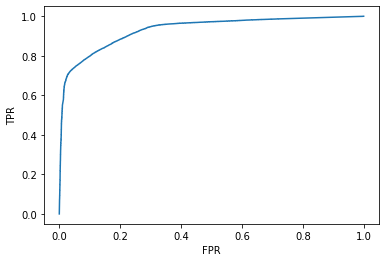

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, Y_test_prob_logistic)

plt.plot(fpr_logistic,tpr_logistic)

plt.xlabel('FPR')
plt.ylabel('TPR')
auc_logistic = auc(fpr_logistic,tpr_logistic)
print('AUC of logistic regression with L2 Penalty', auc_logistic)

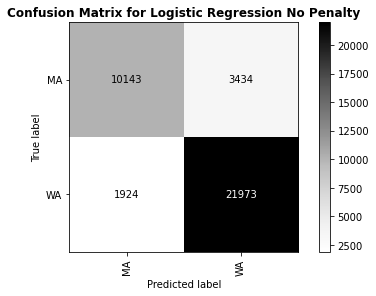

In [0]:
plot_confusion_matrix(logistic_raw, X_test_LSI, y_test, display_labels=class_names, 
                             values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression with L2 Penalty', fontweight='bold')
plt.show()

## Naive Bayers Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB

gau = GaussianNB()
gau.fit(X_train_LSI, y_train)

Y_test_label_gau = gau.predict(X_test_LSI)
Y_test_prob_gau = gau.predict_proba(X_test_LSI)[:,1]

print('confusion_matrix:\n', confusion_matrix(y_test, Y_test_label_gau))
print('accuracy:', accuracy_score(y_test, Y_test_label_gau))
print('recall:', recall_score(y_test, Y_test_label_gau))
print('precision:', precision_score(y_test, Y_test_label_gau))
print('F-1 score:', f1_score(y_test, Y_test_label_gau))

confusion_matrix:
 [[ 8891  4686]
 [ 4241 19656]]
accuracy: 0.7617815018412766
recall: 0.8225300246892916
precision: 0.8074932215923096
F-1 score: 0.8149422666307344


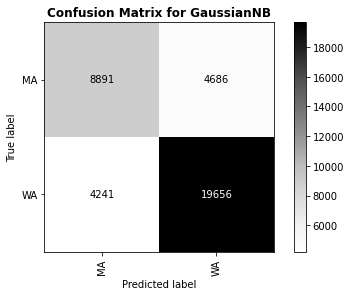

In [0]:
plot_confusion_matrix(gau, X_test_LSI, y_test, display_labels=class_names, 
                             values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for GaussianNB', fontweight='bold')
plt.show()

AUC of GaussianNB 0.818936279739672


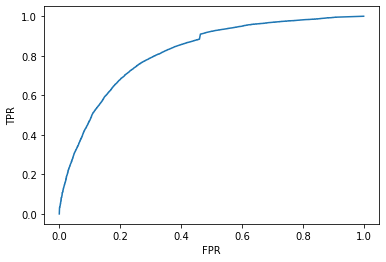

In [0]:
fpr_gau, tpr_gau, _ = roc_curve(y_test, Y_test_prob_gau)

plt.plot(fpr_gau,tpr_gau)

plt.xlabel('FPR')
plt.ylabel('TPR')
auc_gau = auc(fpr_gau,tpr_gau)
print('AUC of GaussianNB', auc_gau)

## Adaboost Classifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.03, random_state=42)
ada.fit(X_train_LSI, y_train)

Y_test_label_ada = ada.predict(X_test_LSI)
Y_test_prob_ada = ada.predict_proba(X_test_LSI)[:,1]

print('confusion_matrix:\n', confusion_matrix(y_test, Y_test_label_ada))
print('accuracy:', accuracy_score(y_test, Y_test_label_ada))
print('recall:', recall_score(y_test, Y_test_label_ada))
print('precision:', precision_score(y_test, Y_test_label_ada))
print('F-1 score:', f1_score(y_test, Y_test_label_ada))


confusion_matrix:
 [[ 8707  4870]
 [ 2055 21842]]
accuracy: 0.8152052089448685
recall: 0.9140059421684731
precision: 0.8176849356094639
F-1 score: 0.8631666304412259


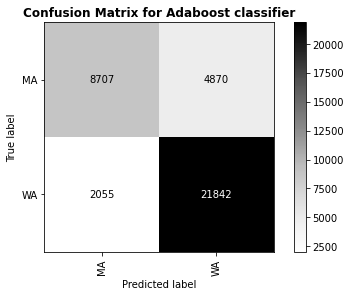

In [0]:
plot_confusion_matrix(ada, X_test_LSI, y_test, display_labels=class_names, 
values_format='d', xticks_rotation=90, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Adaboost classifier', fontweight='bold')
plt.show()


AUC of Adaboost classifier 0.9055673826461457


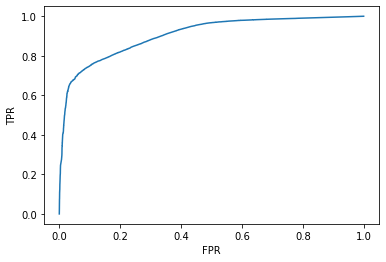

In [0]:
fpr_ada, tpr_ada, _ = roc_curve(y_test, Y_test_prob_ada)

plt.plot(fpr_ada,tpr_ada)

plt.xlabel('FPR')
plt.ylabel('TPR')
auc_ada = auc(fpr_ada,tpr_ada)
print('AUC of Adaboost classifier', auc_ada)
